
MODEL EVALUATION - ADULT DATASET

Evaluating Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Random Forest Performance on Adult Dataset:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       103
           1       0.94      0.87      0.90        38

    accuracy                           0.95       141
   macro avg       0.95      0.92      0.94       141
weighted avg       0.95      0.95      0.95       141



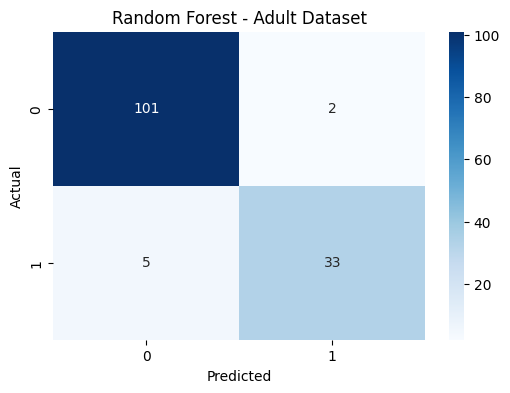

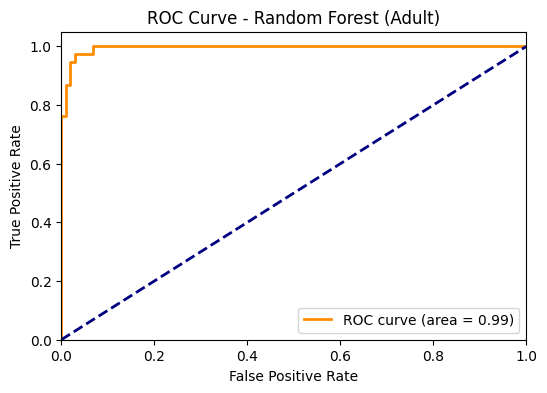

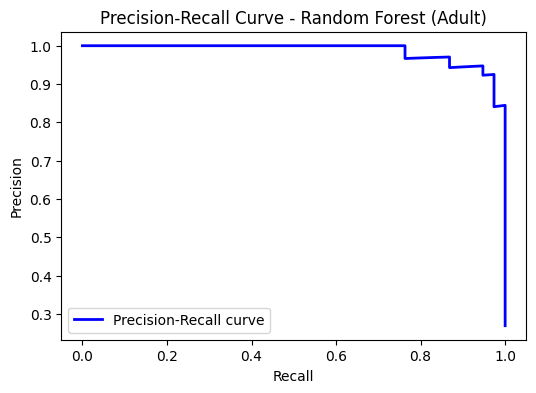

<Figure size 1000x600 with 0 Axes>

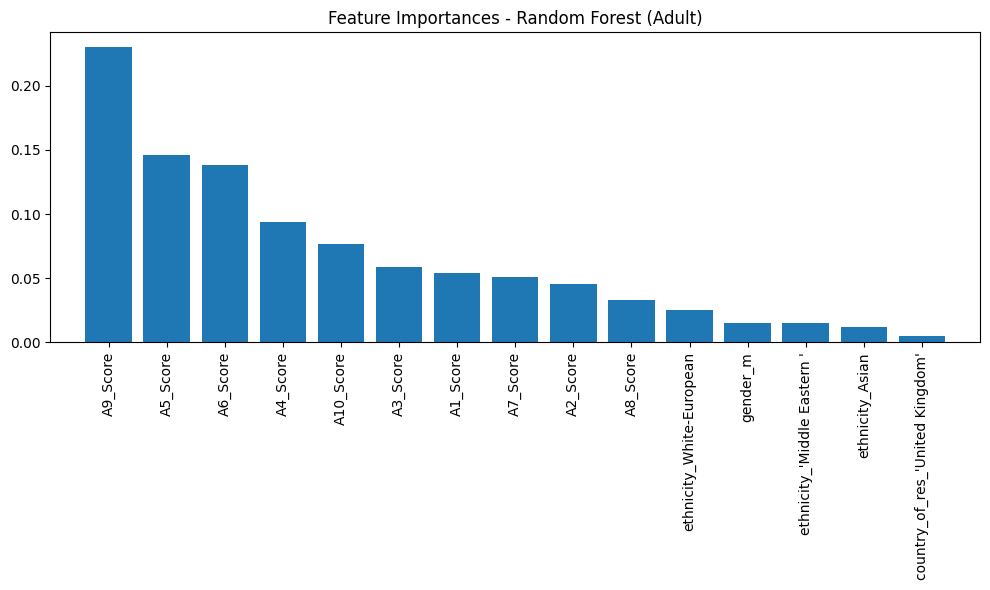

<Figure size 1000x600 with 0 Axes>

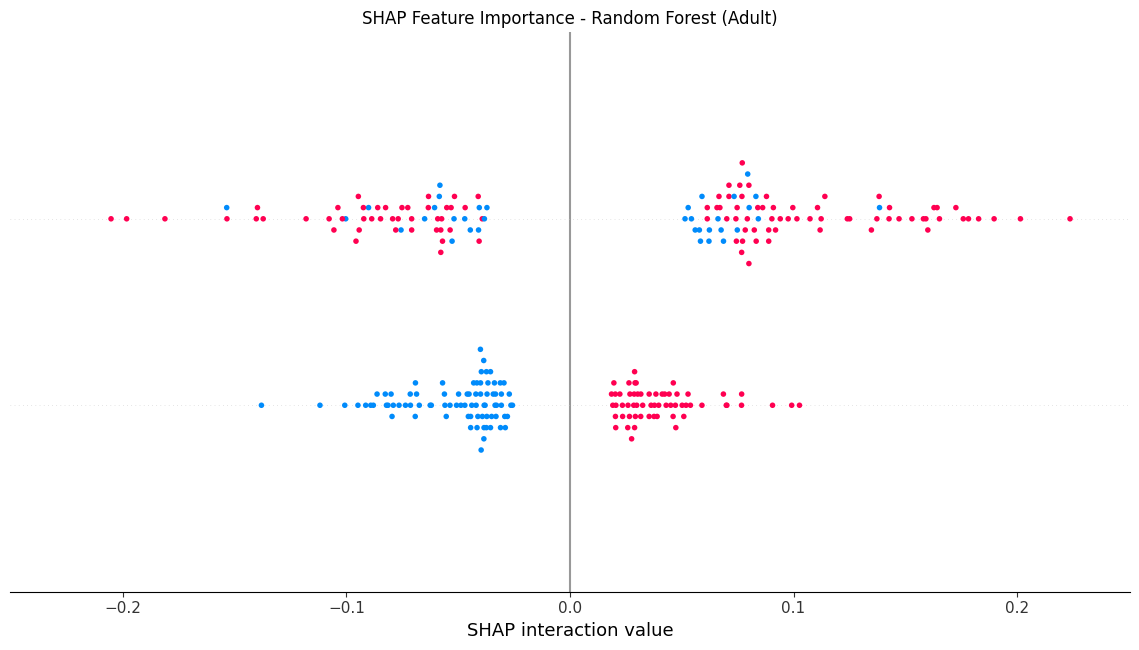

Saved best adult model as 'best_adult_model.joblib'

Evaluating Logistic Regression...

Logistic Regression Performance on Adult Dataset:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       103
           1       1.00      0.95      0.97        38

    accuracy                           0.99       141
   macro avg       0.99      0.97      0.98       141
weighted avg       0.99      0.99      0.99       141



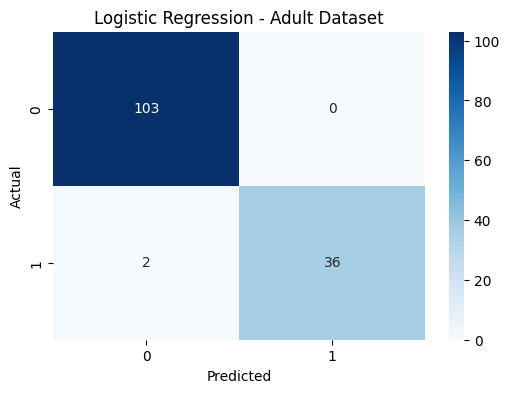

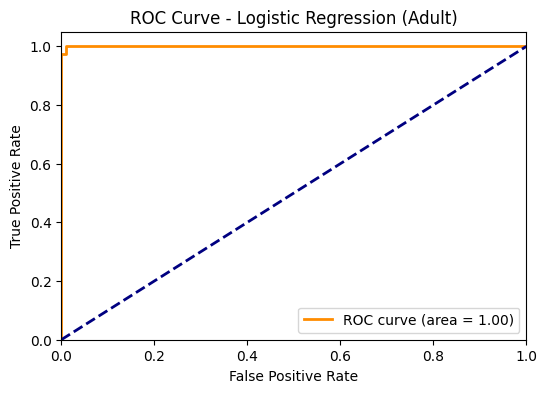

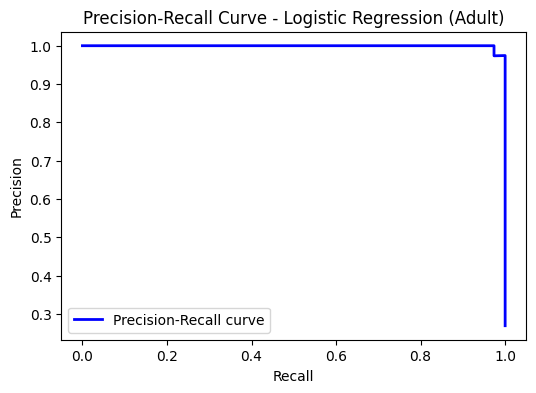

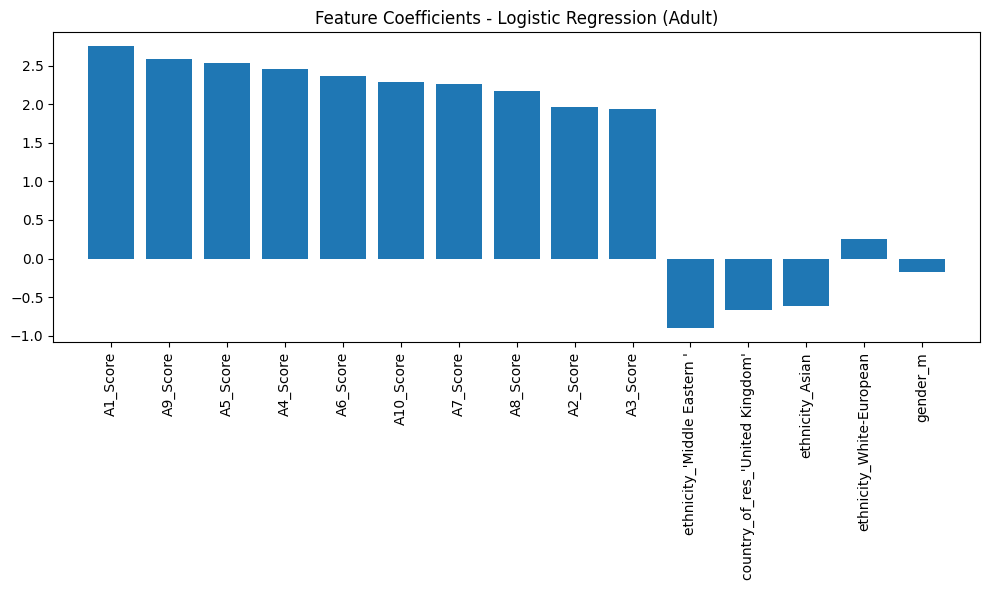


Evaluating XGBoost...

XGBoost Performance on Adult Dataset:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       103
           1       0.95      0.97      0.96        38

    accuracy                           0.98       141
   macro avg       0.97      0.98      0.97       141
weighted avg       0.98      0.98      0.98       141



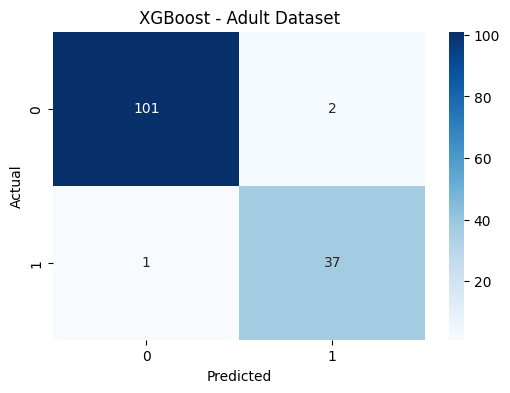

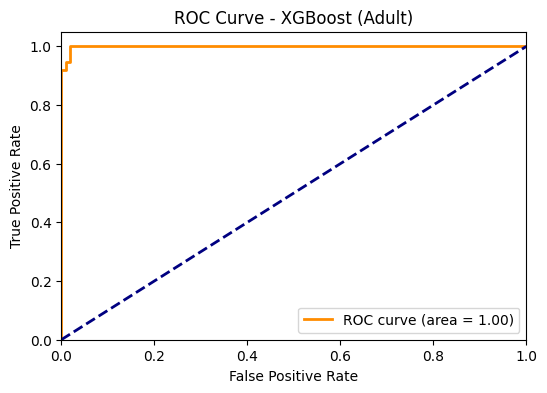

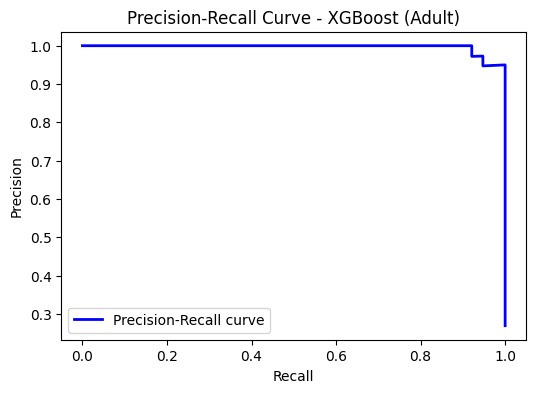

<Figure size 1000x600 with 0 Axes>

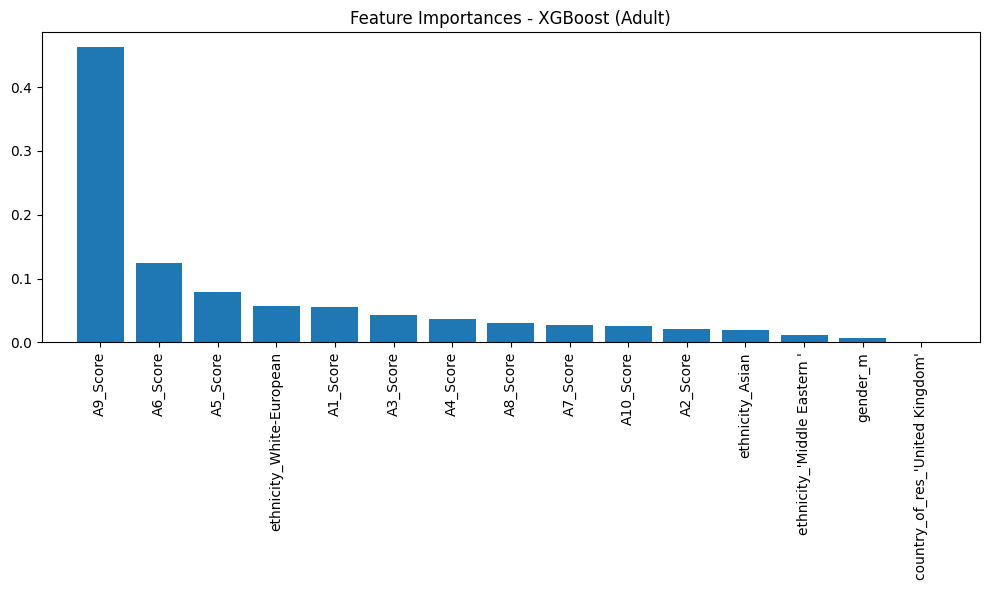

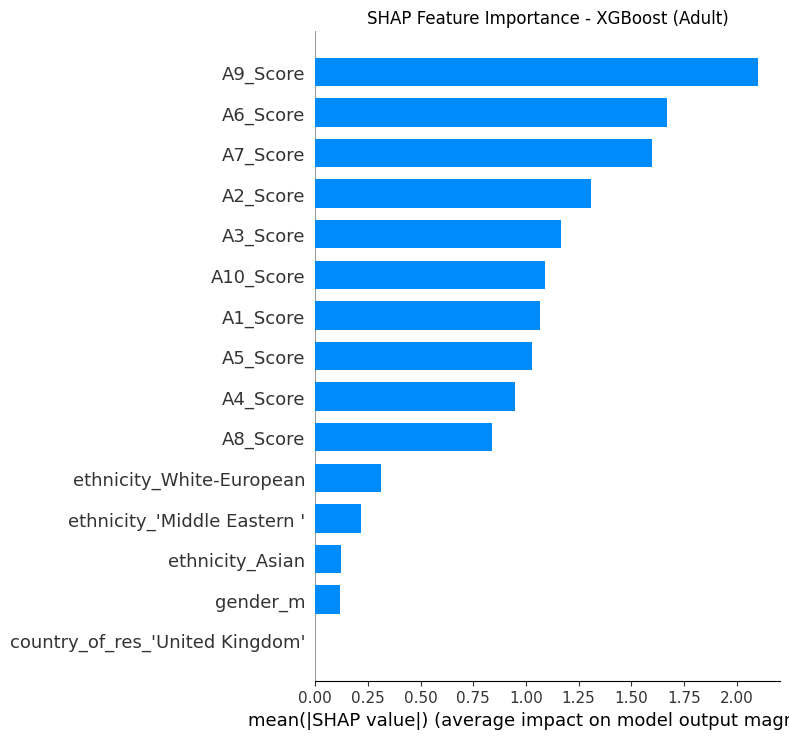


MODEL EVALUATION - CHILDREN DATASET

Evaluating Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Random Forest Performance on Children Dataset:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.90      0.96      0.93        28

    accuracy                           0.93        58
   macro avg       0.93      0.93      0.93        58
weighted avg       0.93      0.93      0.93        58



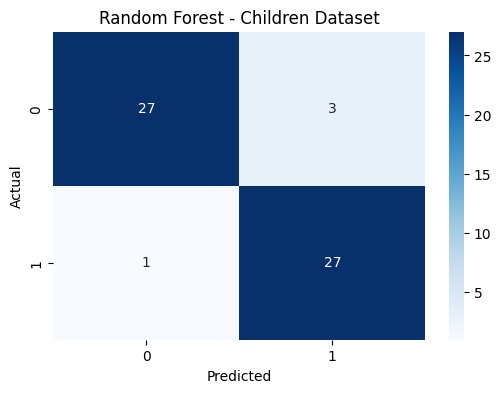

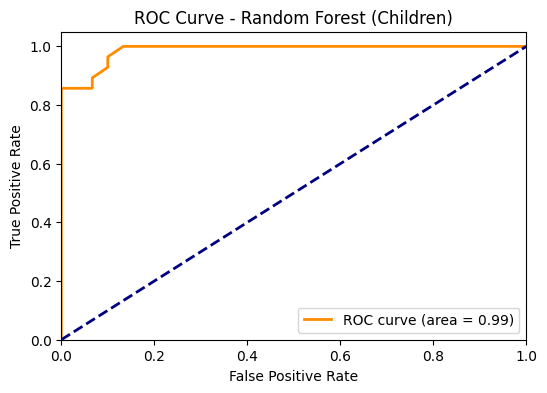

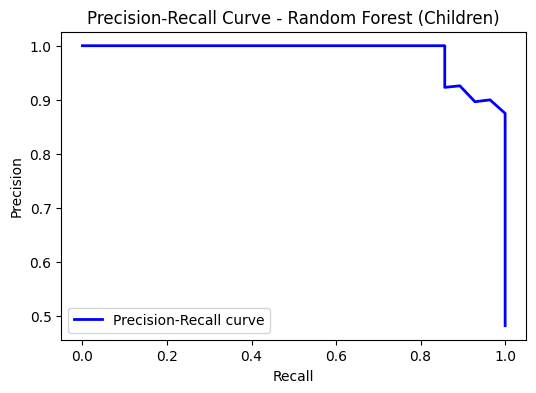

<Figure size 1000x600 with 0 Axes>

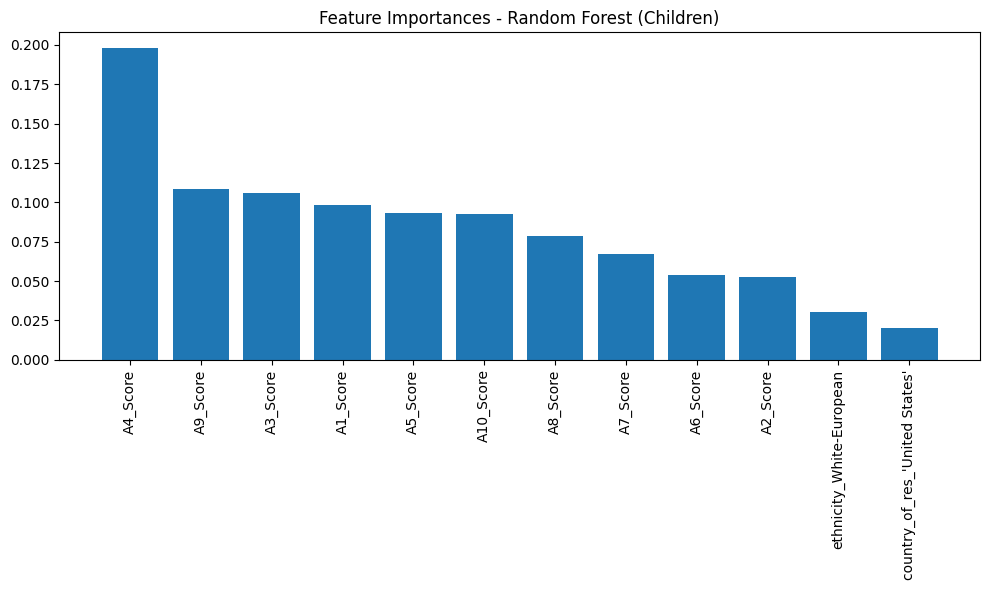

<Figure size 1000x600 with 0 Axes>

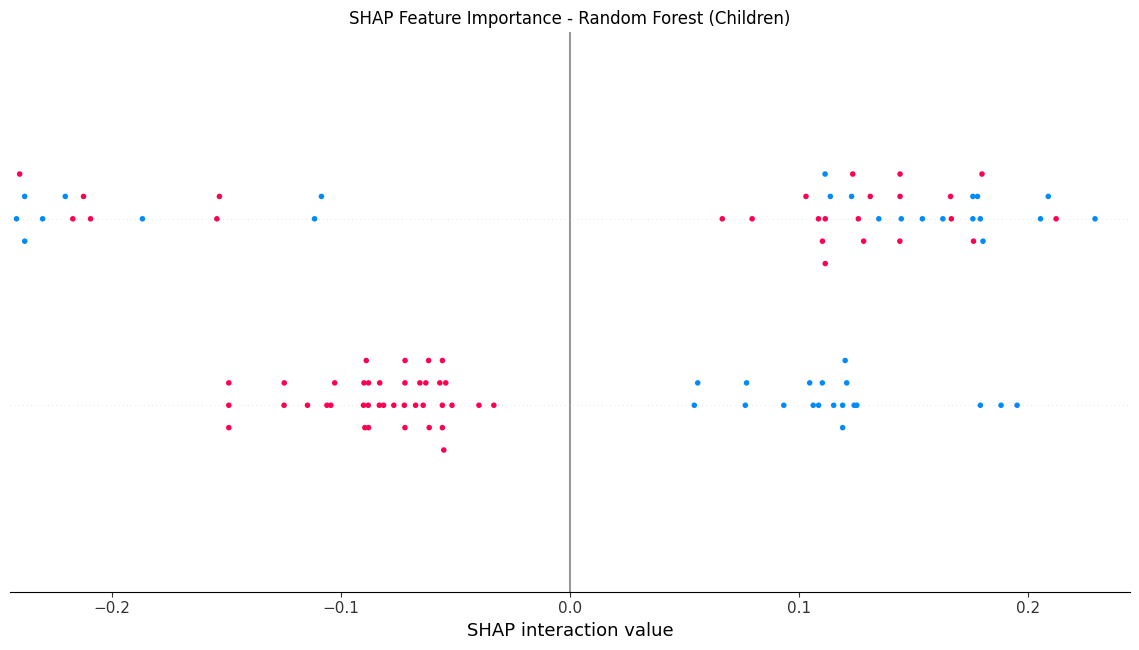

Saved best children model as 'best_children_model.joblib'

Evaluating Logistic Regression...

Logistic Regression Performance on Children Dataset:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        28

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



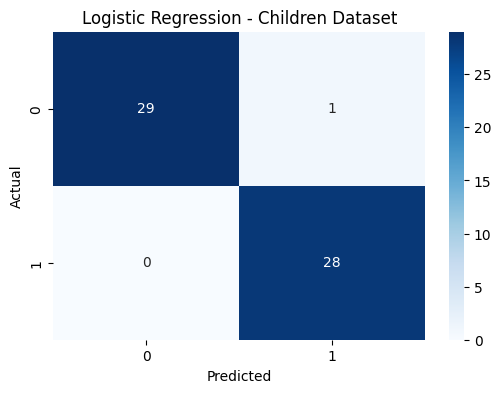

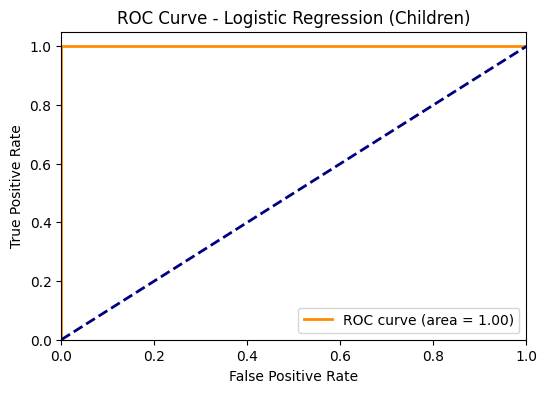

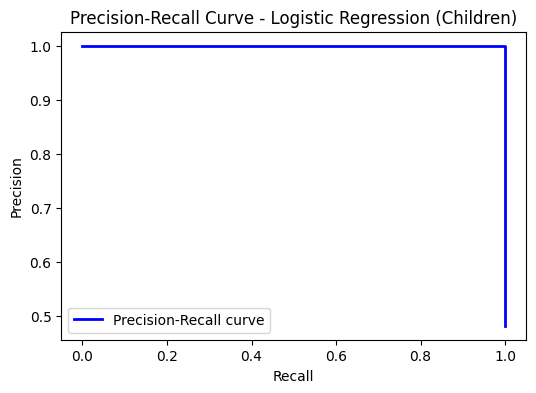

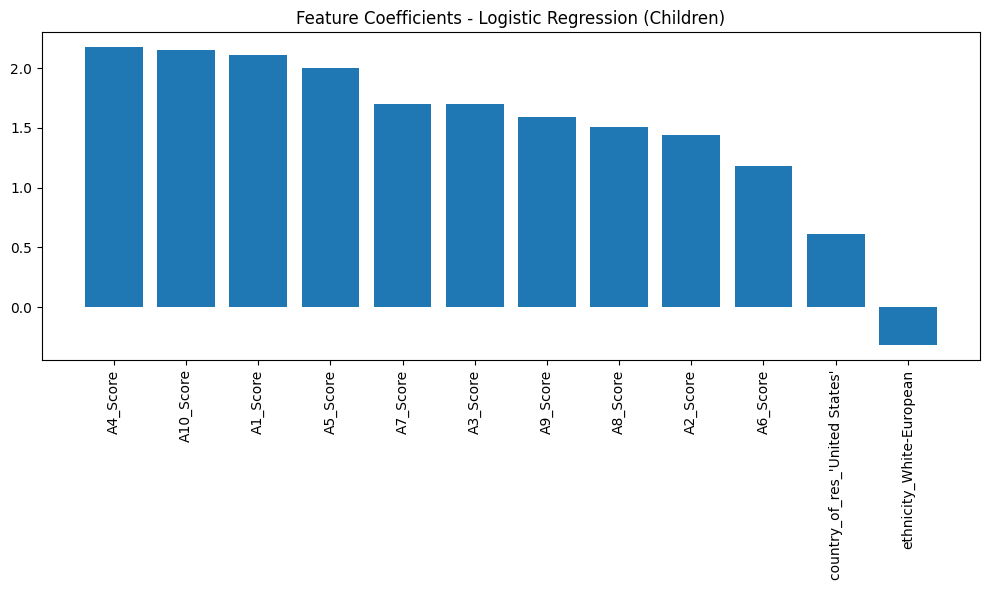


Evaluating XGBoost...

XGBoost Performance on Children Dataset:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.93        28

    accuracy                           0.93        58
   macro avg       0.94      0.93      0.93        58
weighted avg       0.94      0.93      0.93        58



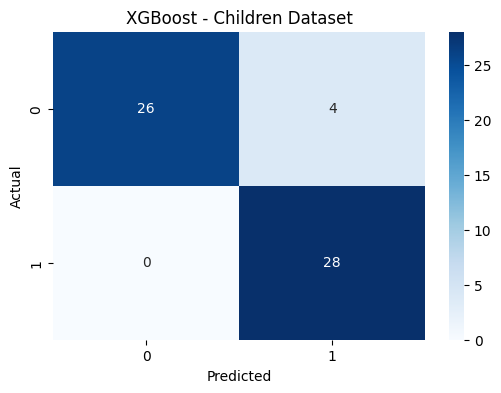

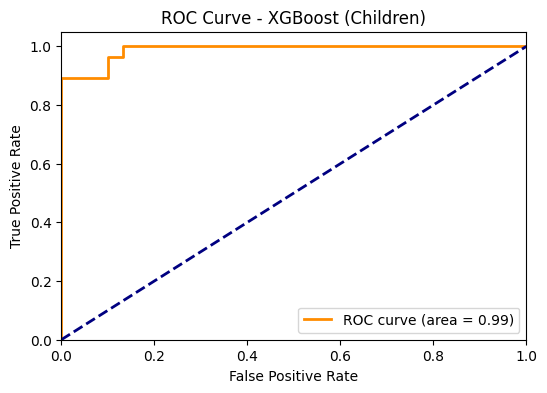

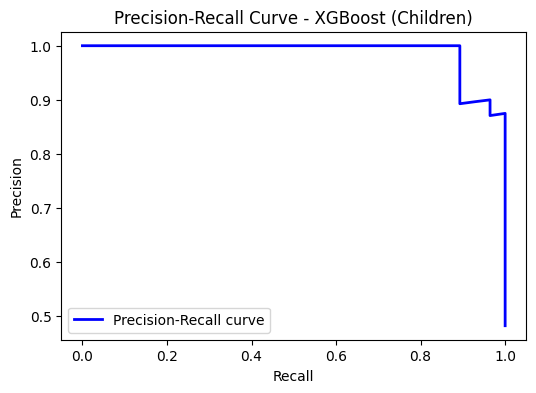

<Figure size 1000x600 with 0 Axes>

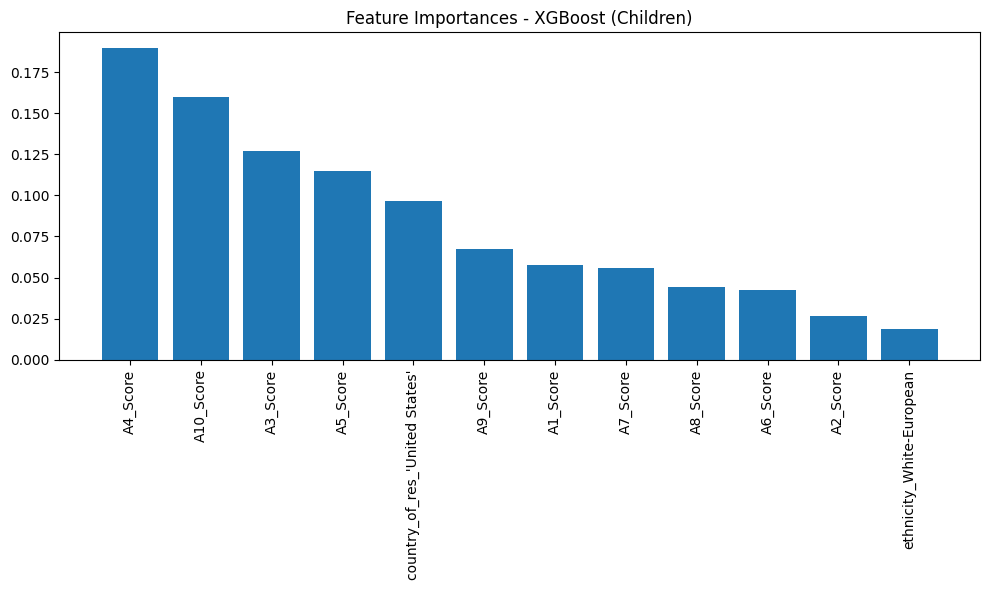

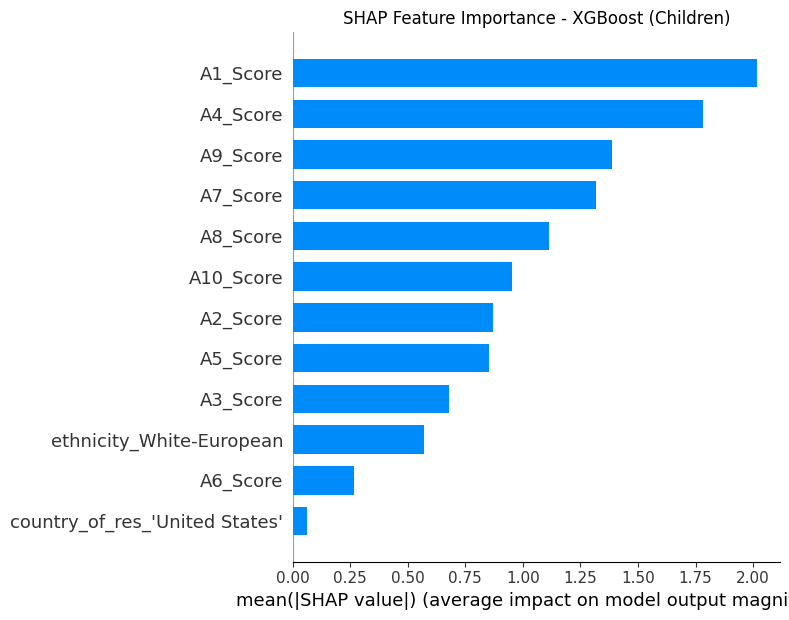


Summary of All Results:
| Dataset   | Model               |   Accuracy |   Balanced Accuracy |   Precision |   Recall (Sensitivity) |   Specificity |       F1 |   ROC AUC |
|:----------|:--------------------|-----------:|--------------------:|------------:|-----------------------:|--------------:|---------:|----------:|
| Adult     | Random Forest       |   0.950355 |            0.924502 |    0.942857 |               0.868421 |      0.980583 | 0.90411  |  0.99489  |
| Adult     | Logistic Regression |   0.985816 |            0.973684 |    1        |               0.947368 |      1        | 0.972973 |  0.999745 |
| Adult     | XGBoost             |   0.978723 |            0.977133 |    0.948718 |               0.973684 |      0.980583 | 0.961039 |  0.998723 |
| Children  | Random Forest       |   0.931034 |            0.932143 |    0.9      |               0.964286 |      0.9      | 0.931034 |  0.986905 |
| Children  | Logistic Regression |   0.982759 |            0.983333 |    0.96551

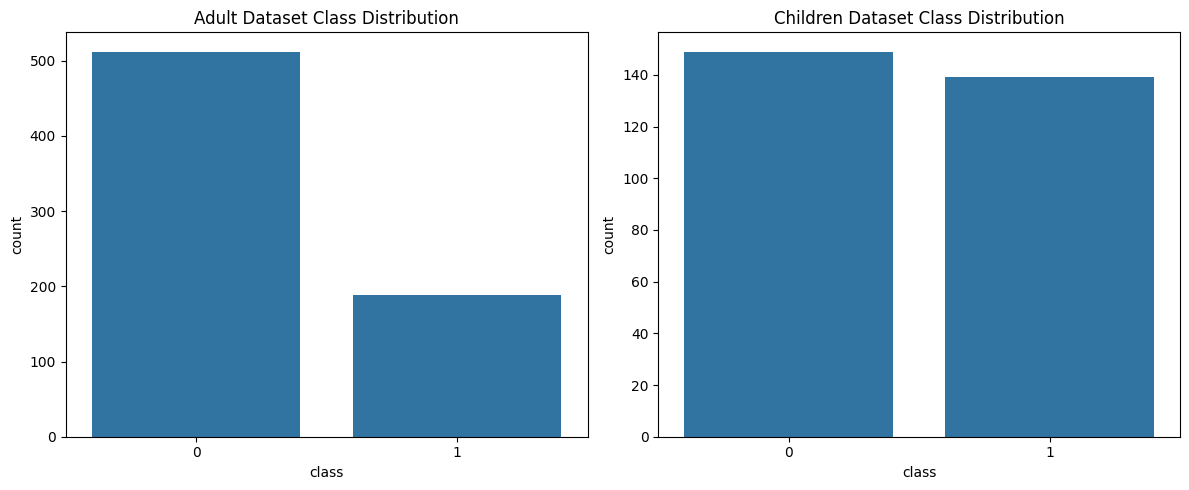

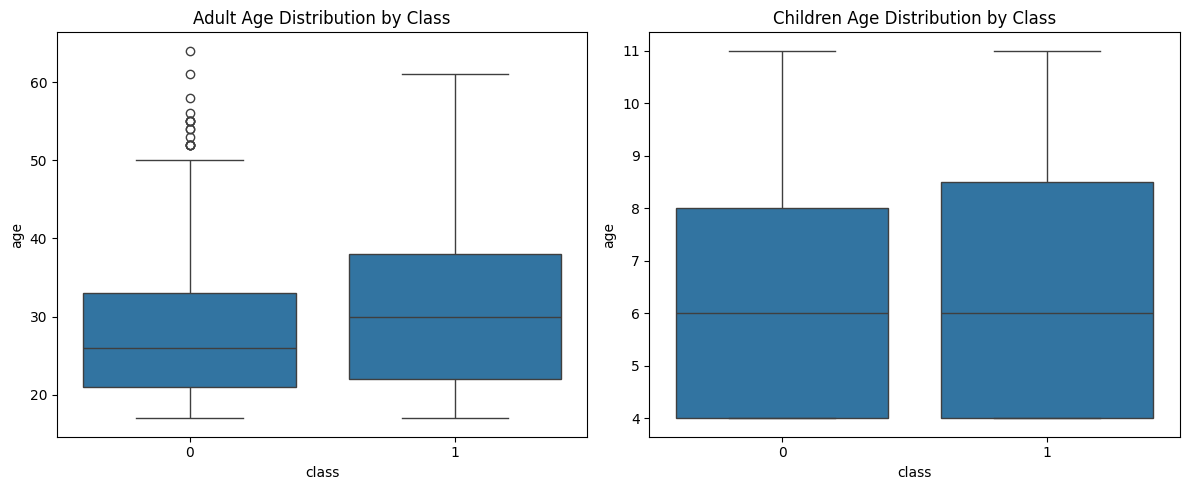

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                           recall_score, f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load datasets
def load_data():
    """Load and return adult and children datasets"""
    adult_df = pd.read_csv('adult.csv')
    children_df = pd.read_csv('children.csv')
    return adult_df, children_df

# Data preprocessing
def preprocess_data(df, dataset_type='adult'):
    """Preprocess the dataset with cleaning and basic feature engineering"""
    df = df.copy()

    # Drop redundant columns
    df = df.drop(['age_desc'], axis=1, errors='ignore')

    # Handle missing values
    df['ethnicity'] = df['ethnicity'].fillna('Unknown')
    df = df.dropna(subset=['age'])

    # Remove age outliers
    df = df[df['age'] < 100]

    # Standardize categorical columns
    df['gender'] = df['gender'].str.lower().str.strip()
    df['ethnicity'] = df['ethnicity'].str.strip()

    # Convert binary features to numeric
    binary_cols = ['jaundice', 'used_app_before']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'yes': 1, 'no': 0})

    # Handle autism/family history column
    if dataset_type == 'children':
        df['autism'] = df['autism'].map({'yes': 1, 'no': 0})
    else:
        df['family_pdd'] = df['family_pdd'].map({'yes': 1, 'no': 0})

    # Encode target variable
    df['class'] = df['class'].map({'NO': 0, 'YES': 1})

    return df

# Prepare data for modeling
def prepare_data(df, target='class', test_size=0.2):
    """Split data into train/test sets"""
    # We'll do all preprocessing inside the pipeline to prevent data leakage
    X = df.drop([target, 'result'], axis=1, errors='ignore')  # Explicitly drop 'result' to prevent leakage
    y = df[target]

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test, categorical_cols, numerical_cols

# Model evaluation with comprehensive metrics
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, dataset_name):
    """Evaluate model and return metrics with visualizations"""
    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    try:
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:,1]
    except Exception as e:
        print(f"Error during prediction for {model_name}: {str(e)}")
        return None

    # Calculate metrics
    metrics = {
        'Dataset': dataset_name,
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'Specificity': recall_score(y_test, y_pred, pos_label=0),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

    # Print classification report (same as before)
    print(f"\n{model_name} Performance on {dataset_name} Dataset:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix (same as before)
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
               annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - {dataset_name} Dataset')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve (same as before)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
            label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} ({dataset_name})')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve (same as before)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, color='blue', lw=2,
            label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name} ({dataset_name})')
    plt.legend(loc="lower left")
    plt.show()

    # Improved Feature Importance Visualization
    try:
        preprocessor = pipeline.named_steps['preprocessor']
        feature_names = []

        # Numerical features
        if 'num' in preprocessor.named_transformers_:
            num_features = preprocessor.transformers_[0][2]
            feature_names.extend(num_features)

        # Categorical features
        if 'cat' in preprocessor.named_transformers_:
            cat_features = preprocessor.transformers_[1][2]
            ohe = preprocessor.named_transformers_['cat']
            cat_feature_names = ohe.get_feature_names_out(cat_features)
            feature_names.extend(cat_feature_names)

        # Handle feature selection
        if 'feature_selector' in pipeline.named_steps:
            selector = pipeline.named_steps['feature_selector']
            if hasattr(selector, 'get_support'):
                support = selector.get_support()
                feature_names = np.array(feature_names)[support]

        # Different approaches for different models
        classifier = pipeline.named_steps['classifier']

        plt.figure(figsize=(10, 6))

        if hasattr(classifier, 'feature_importances_'):  # Tree-based models
            importances = classifier.feature_importances_
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(10, 6))
            plt.title(f"Feature Importances - {model_name} ({dataset_name})")
            plt.bar(range(len(importances)), importances[indices], align="center")
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            plt.xlim([-1, len(importances)])
            plt.tight_layout()
            plt.show()

    # SHAP analysis
            try:
        # Get transformed test data
                X_test_transformed = preprocessor.transform(X_test)
                if hasattr(selector, 'transform'):
                    X_test_transformed = selector.transform(X_test_transformed)

        # Convert to dense array and ensure numeric type
                if hasattr(X_test_transformed, "toarray"):  # For sparse matrices
                    X_test_transformed = X_test_transformed.toarray()
                X_test_transformed = np.array(X_test_transformed, dtype=np.float32)  # Force float type

        # Filter out non-numeric columns (just in case)
                numeric_mask = np.all(np.isfinite(X_test_transformed), axis=0)
                X_test_transformed = X_test_transformed[:, numeric_mask]
                filtered_feature_names = np.array(feature_names)[numeric_mask]

        # Compute SHAP values
                explainer = shap.TreeExplainer(classifier)
                shap_values = explainer.shap_values(X_test_transformed)

        # Plot SHAP summary
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, X_test_transformed,
                                 feature_names=filtered_feature_names,
                                 plot_type="bar",
                                 show=False)
                plt.title(f'SHAP Feature Importance - {model_name} ({dataset_name})')
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Could not generate SHAP plot: {str(e)}")
                import traceback
                traceback.print_exc()

        elif hasattr(classifier, 'coef_'):  # Linear models
            coef = classifier.coef_[0]
            indices = np.argsort(np.abs(coef))[::-1]

            plt.title(f"Feature Coefficients - {model_name} ({dataset_name})")
            plt.bar(range(len(coef)), coef[indices], align="center")
            plt.xticks(range(len(coef)), [feature_names[i] for i in indices], rotation=90)
            plt.xlim([-1, len(coef)])
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Could not generate feature importance plots: {str(e)}")

    return metrics


# Main execution function
def main():
    # Load and preprocess data
    adult_df, children_df = load_data()
    adult_df = preprocess_data(adult_df, 'adult')
    children_df = preprocess_data(children_df, 'children')

    # Prepare data
    X_train_adult, X_test_adult, y_train_adult, y_test_adult, cat_cols_adult, num_cols_adult = prepare_data(adult_df)
    X_train_children, X_test_children, y_train_children, y_test_children, cat_cols_children, num_cols_children = prepare_data(children_df)

    # Define preprocessing steps
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Define the best pipeline structure
    def create_pipeline(model, categorical_cols, numerical_cols):
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        return ImbPipeline([
            ('preprocessor', preprocessor),
            ('feature_selector', SelectFromModel(
                LogisticRegression(penalty='l1', solver='liblinear', random_state=42))),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])

    # Define models to evaluate
    models = {
        'Random Forest': RandomForestClassifier(
            class_weight='balanced',
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            scale_pos_weight=(y_train_adult.value_counts()[0]/y_train_adult.value_counts()[1]),
            random_state=42,
            eval_metric='logloss',
            enable_categorical=False
        )
    }

    # Hyperparameter grid for Random Forest
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }

    # Evaluate models on adult dataset
    print("\n" + "="*60)
    print("MODEL EVALUATION - ADULT DATASET")
    print("="*60)

    adult_results = []
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        pipeline = create_pipeline(model, cat_cols_adult, num_cols_adult)

        # Grid search for Random Forest
        if name == 'Random Forest':
            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                scoring='f1',
                n_jobs=-1
            )
            try:
                grid_search.fit(X_train_adult, y_train_adult)
                best_pipeline = grid_search.best_estimator_
                print(f"Best parameters for {name}: {grid_search.best_params_}")
                metrics = evaluate_model(
                    best_pipeline, X_train_adult, X_test_adult,
                    y_train_adult, y_test_adult, name, 'Adult')

                if metrics:
                    adult_results.append(metrics)
                    # Save the best model
                    joblib.dump(best_pipeline, 'best_adult_model.joblib')
                    print("Saved best adult model as 'best_adult_model.joblib'")
            except Exception as e:
                print(f"Error during grid search for {name}: {str(e)}")
        else:
            metrics = evaluate_model(
                pipeline, X_train_adult, X_test_adult,
                y_train_adult, y_test_adult, name, 'Adult')
            if metrics:
                adult_results.append(metrics)

    # Evaluate models on children dataset
    print("\n" + "="*60)
    print("MODEL EVALUATION - CHILDREN DATASET")
    print("="*60)

    children_results = []
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        pipeline = create_pipeline(model, cat_cols_children, num_cols_children)

        # Grid search for Random Forest
        if name == 'Random Forest':
            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                scoring='f1',
                n_jobs=-1
            )
            try:
                grid_search.fit(X_train_children, y_train_children)
                best_pipeline = grid_search.best_estimator_
                print(f"Best parameters for {name}: {grid_search.best_params_}")
                metrics = evaluate_model(
                    best_pipeline, X_train_children, X_test_children,
                    y_train_children, y_test_children, name, 'Children')

                if metrics:
                    children_results.append(metrics)
                    # Save the best model
                    joblib.dump(best_pipeline, 'best_children_model.joblib')
                    print("Saved best children model as 'best_children_model.joblib'")
            except Exception as e:
                print(f"Error during grid search for {name}: {str(e)}")
        else:
            metrics = evaluate_model(
                pipeline, X_train_children, X_test_children,
                y_train_children, y_test_children, name, 'Children')
            if metrics:
                children_results.append(metrics)

    # Create and display results dataframe
    if adult_results or children_results:
        results_df = pd.DataFrame(adult_results + children_results)
        print("\nSummary of All Results:")
        print(results_df.to_markdown(index=False))
    else:
        print("\nNo results to display due to errors in all models")

    # Additional data analysis
    print("\n" + "="*60)
    print("ADDITIONAL DATA ANALYSIS")
    print("="*60)

    # Class distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x='class', data=adult_df)
    plt.title('Adult Dataset Class Distribution')
    plt.subplot(1, 2, 2)
    sns.countplot(x='class', data=children_df)
    plt.title('Children Dataset Class Distribution')
    plt.tight_layout()
    plt.show()

    # Age distribution by class
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='class', y='age', data=adult_df)
    plt.title('Adult Age Distribution by Class')
    plt.subplot(1, 2, 2)
    sns.boxplot(x='class', y='age', data=children_df)
    plt.title('Children Age Distribution by Class')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()